# 0. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
import time
from datetime import timedelta

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import DataLoader
torch.manual_seed(123)

# 1. Data Read In

In [2]:
cn7 = pd.read_csv("../data/processed/labeled_data_cn7.csv", parse_dates=True)

# 2. Data Preprocessing for Train/Test Split

In [3]:
numerical_features = [x for x in cn7.columns if np.dtype(cn7[x]) == "float64"]

In [4]:
cn7["PassOrFail"].value_counts()

0    3946
1      28
Name: PassOrFail, dtype: int64

In [5]:
# Data for passed parts
cn7_Y = cn7[cn7["PassOrFail"] == 0]
print("No. of passed CN7 parts:", len(cn7_Y))

No. of passed CN7 parts: 3946


In [6]:
# Data for Failed parts
cn7_N = cn7[cn7["PassOrFail"] == 1]
print("No. of failed CN7 parts:", len(cn7_N))

No. of failed CN7 parts: 28


** The data format for Denoising autoencoders must not have class in the data. So `PassOrFail` needs to be removed.

In [7]:
# Data for passed parts
cn7_Y = cn7_Y[numerical_features]
# Data for Failed parts
cn7_N = cn7_N[numerical_features]

#### 학습/평가 데이터 분리 (9:1 비율)

In [8]:
cn7_Y.shape

(3946, 23)

In [9]:
cn7_train_Y, cn7_test_Y = train_test_split(cn7_Y, test_size=0.1)

# 평가 데이터 (불량)
cn7_test_N = cn7_N

print(f"CN7 학습 데이터 (양품) 개수: {len(cn7_train_Y)}")
print(f"CN7 평가 데이터 (양품) 개수: {len(cn7_test_Y)}")
print(f"CN7 평가 데이터 (불량) 개수: {len(cn7_test_N)}")

CN7 학습 데이터 (양품) 개수: 3551
CN7 평가 데이터 (양품) 개수: 395
CN7 평가 데이터 (불량) 개수: 28


In [10]:
scaler = StandardScaler()

cn7_train_Y = scaler.fit_transform(cn7_train_Y)
cn7_test_Y = scaler.transform(cn7_test_Y)
cn7_test_N = scaler.transform(cn7_test_N)

# 3. Variational Autoencoder 모델링

In [11]:
cn7_train_Y.shape

(3551, 23)

In [12]:
# Autoencoder Class

class VariationalAutoEncoder(nn.Module):
    def __init__(self):
        super(VariationalAutoEncoder, self).__init__()
        self.N = torch.distributions.Normal(0, 1)
        self.kl = 0
        
        self.enc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(cn7_train_Y.shape[1], 15),
            nn.ReLU(),
            nn.Linear(15, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
        )
        
        self.dec = nn.Sequential(
            nn.Linear(1, 5),
            nn.ReLU(),
            nn.Linear(5, 15),
            nn.ReLU(),
            nn.Linear(15, cn7_train_Y.shape[1]),
            # nn.ReLU(),
        )
        
    def forward(self, x):
        x = self.enc(x)
        mu = x
        sigma = torch.exp(x)
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()  # Came from Kullback-Leibler Divergence
        return self.dec(z)

In [13]:
# Training Parameters

batch_size = 30
lr = 0.001   # learning rate
w_d = 1e-4  # weight decay
epochs = 30

In [14]:
# Loader Preparation

class Loader(torch.utils.data.Dataset):
    def __init__(self):
        super(Loader, self).__init__()
        self.dataset = ''
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        row = self.dataset[idx]
        # row = self.dataset.iloc[idx]
        data = torch.from_numpy(row).float()
        return data
    
    
class CN7DataLoader(Loader):
    def __init__(self, data_for_ae):
        super(CN7DataLoader, self).__init__()
        self.dataset = data_for_ae

In [15]:
# train/validation sets split

cn7_train_Y_t, cn7_train_Y_v = train_test_split(
    cn7_train_Y, test_size=0.2, random_state=123
)

In [16]:
train_set = CN7DataLoader(cn7_train_Y_t)

train_ = DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)

In [17]:
valid_set = CN7DataLoader(cn7_train_Y_v)

valid_ = DataLoader(
    valid_set,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=True
)

In [18]:
metrics = defaultdict(list)
device = 'cpu'       #'cuda' if torch.cuda.is_available() else 'cpu'
model = VariationalAutoEncoder()
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=lr, weight_decay=w_d
)

In [19]:
summary(model, (23, ), device='cpu');

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1]                   --
|    └─Dropout: 2-1                      [-1, 23]                  --
|    └─Linear: 2-2                       [-1, 15]                  360
|    └─ReLU: 2-3                         [-1, 15]                  --
|    └─Linear: 2-4                       [-1, 5]                   80
|    └─ReLU: 2-5                         [-1, 5]                   --
|    └─Linear: 2-6                       [-1, 1]                   6
├─Sequential: 1-2                        [-1, 23]                  --
|    └─Linear: 2-7                       [-1, 5]                   10
|    └─ReLU: 2-8                         [-1, 5]                   --
|    └─Linear: 2-9                       [-1, 15]                  90
|    └─ReLU: 2-10                        [-1, 15]                  --
|    └─Linear: 2-11                      [-1, 23]                  368
Total params: 

In [20]:
# VAE Training

model.train()
start = time.time()
for epoch in range(epochs):
    ep_start = time.time()
    
    # Training
    running_loss_t = 0.0

    for bx, (data) in enumerate(train_):
        sample = model(data.to(device))
        loss = criterion(data.to(device), sample)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss_t += loss.item()
    train_loss = running_loss_t/len(train_set)
    metrics['train_loss'].append(train_loss)
    
    # Validation
    model.eval()
    running_loss_v = 0.0
    with torch.no_grad():
        for bx, (data) in enumerate(valid_):
            sample = model(data.to(device))
            loss = criterion(data.to(device), sample)
            accuracy = torch.sum(torch.isclose(data.to(device), sample, rtol=0.1))
            running_loss_v += loss.item()
    valid_loss = running_loss_v/len(valid_set)
    metrics['valid_loss'].append(valid_loss)
    
    model.train()
    
    ep_end = time.time()
    if (epoch+1) % 5 == 0:
        print('-----------------------------------------------')
        print('[EPOCH] {}/{}\n[TRAIN LOSS] {}    [VALID LOSS] {}'.format(epoch+1, epochs, train_loss, valid_loss))
        print('Epoch Complete in {}'.format(timedelta(seconds=ep_end-ep_start)))
end = time.time()
print('-----------------------------------------------')
print('[System Complete: {}]'.format(timedelta(seconds=end-start)))

-----------------------------------------------
[EPOCH] 5/30
[TRAIN LOSS] 0.0317402704605754    [VALID LOSS] 0.020585770911305264
Epoch Complete in 0:00:00.173032
-----------------------------------------------
[EPOCH] 10/30
[TRAIN LOSS] 0.029483080802249238    [VALID LOSS] 0.02010096626358864
Epoch Complete in 0:00:00.175004
-----------------------------------------------
[EPOCH] 15/30
[TRAIN LOSS] 0.029837050514531806    [VALID LOSS] 0.01820154460841258
Epoch Complete in 0:00:00.174998
-----------------------------------------------
[EPOCH] 20/30
[TRAIN LOSS] 0.029093017229731653    [VALID LOSS] 0.020371146845918165
Epoch Complete in 0:00:00.178998
-----------------------------------------------
[EPOCH] 25/30
[TRAIN LOSS] 0.025221480271765885    [VALID LOSS] 0.012369897127486817
Epoch Complete in 0:00:00.194031
-----------------------------------------------
[EPOCH] 30/30
[TRAIN LOSS] 0.033389393130028755    [VALID LOSS] 0.01893999684292891
Epoch Complete in 0:00:00.199999
----------

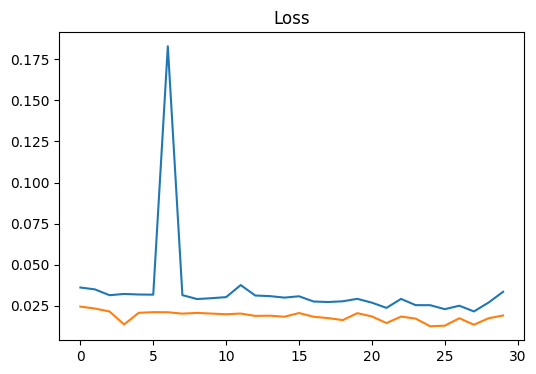

In [21]:
# Loss

_, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_title('Loss')
ax.plot(metrics['train_loss'])
ax.plot(metrics['valid_loss'])
plt.show();

# 4. 임계값 정의

In [22]:
# 학습 데이터의 예측값

cn7_train_pred = model(torch.tensor(cn7_train_Y).float())

In [23]:
cn7_train_pred

tensor([[-0.3096, -0.6803,  0.0983,  ..., -0.1134,  0.0431,  0.1127],
        [ 0.6766,  0.3892,  0.1602,  ...,  0.6065,  0.2141,  0.2790],
        [ 0.6813,  0.3941,  0.1634,  ...,  0.6083,  0.2148,  0.2819],
        ...,
        [ 0.2838, -0.1148,  0.1566,  ...,  0.3119,  0.1674,  0.2048],
        [ 0.0956, -0.3461,  0.1622,  ...,  0.1630,  0.1395,  0.1725],
        [ 0.6789,  0.3916,  0.1618,  ...,  0.6074,  0.2145,  0.2805]],
       grad_fn=<AddmmBackward0>)

In [24]:
# 학습 데이터의 복원 오차 (예측값 - 실제값)

difference = cn7_train_pred.detach().numpy() - cn7_train_Y

cn7_train_loss = np.mean(np.square(difference), axis=1)

In [25]:
cn7_train_loss

array([0.16587017, 0.34917072, 0.12706311, ..., 0.24755898, 0.11310002,
       0.39223614])

In [26]:
# 입계치 (6 시그마 사용)

threshold = np.mean(cn7_train_loss) + 6*np.std(cn7_train_loss)
print("복원 오류 임계치: ", threshold)

복원 오류 임계치:  59.2932428471933


# 5. 데이터 각각의 예측값과 복원 오차 확인

## 5.1. 평가 데이터 (양품) 대상 모델 성능 검증 

In [27]:
# 예측값
cn7_predict_Y = model(torch.tensor(cn7_test_Y).float())

In [28]:
cn7_predict_Y

tensor([[-0.1658, -0.5665,  0.1231,  ..., -0.0162,  0.0778,  0.1354],
        [ 0.6888,  0.4019,  0.1685,  ...,  0.6113,  0.2160,  0.2865],
        [-0.2686, -0.6489,  0.1056,  ..., -0.0849,  0.0525,  0.1209],
        ...,
        [ 0.3016, -0.0929,  0.1561,  ...,  0.3261,  0.1701,  0.2078],
        [ 0.6560,  0.3653,  0.1500,  ...,  0.5967,  0.2118,  0.2690],
        [-0.2906, -0.6665,  0.1019,  ..., -0.0996,  0.0471,  0.1177]],
       grad_fn=<AddmmBackward0>)

In [29]:
# 양품 평가 데이터의 복원 오차 (예측값 - 실제값)

cn7_test_Y_mse = np.mean(np.square(cn7_predict_Y.detach().numpy() - cn7_test_Y), axis=1)

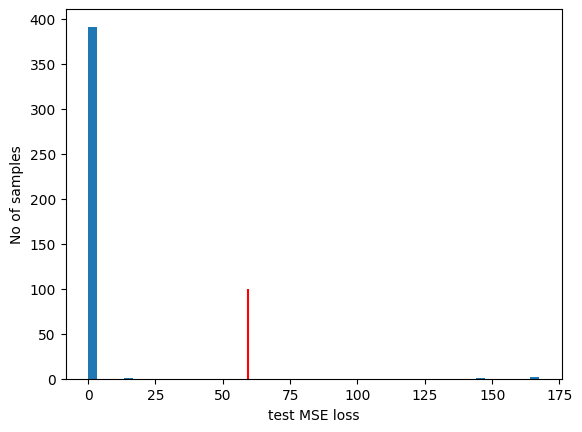

In [30]:
# 시각화

plt.hist(cn7_test_Y_mse, bins=50)
plt.xlabel("test MSE loss")
plt.ylabel("No of samples")
plt.vlines(threshold, 0, 100, color="red")
plt.show();

In [31]:
# 불량으로 판단한 데이터 확인

cn7_test_Y_anomalies = cn7_test_Y_mse > threshold
print("불량 개수: ", np.sum(cn7_test_Y_anomalies))
print("정확도: ", (cn7_test_Y.shape[0]-np.sum(cn7_test_Y_anomalies))/cn7_test_Y.shape[0])

불량 개수:  3
정확도:  0.9924050632911392


## 5.2. 평가 데이터 (불량) 대상 모델 성능 검증 

In [32]:
# 예측값
cn7_predict_N = model(torch.tensor(cn7_test_N).float())

In [33]:
cn7_predict_N.shape

torch.Size([28, 23])

In [34]:
# 불량 평가 데이터의 복원 오차 (예측값 - 실제값)

cn7_test_N_mse = np.mean(np.square(cn7_predict_N.detach().numpy() - cn7_test_N), axis=1)

In [35]:
cn7_test_N_mse

array([3.33187670e-01, 3.76613792e-01, 4.60616189e-01, 4.35501689e-01,
       4.47078757e-01, 4.60921244e-01, 3.66106837e-01, 4.07910647e-01,
       3.90602648e-01, 4.18046419e-01, 4.56677114e-01, 2.37688221e+00,
       2.37839229e+00, 2.74509939e+00, 2.67471129e+00, 2.53285103e+00,
       2.53427569e+00, 1.74535664e+02, 1.76011435e+02, 5.97605854e+01,
       6.02121503e+01, 5.54960835e+01, 5.53789076e+01, 9.51370466e+00,
       9.48163722e+00, 1.15321448e+00, 1.16388915e+00, 1.44609727e-01])

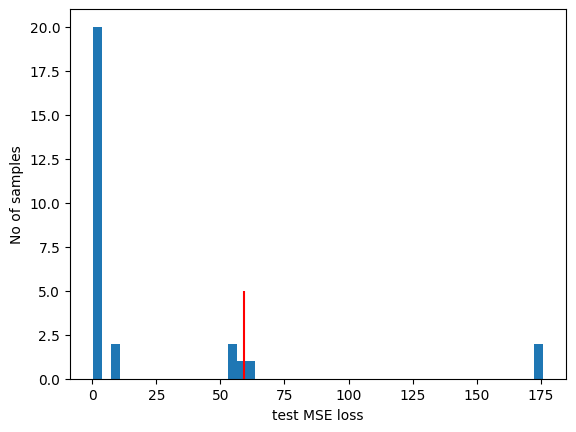

In [36]:
# 시각화

plt.hist(cn7_test_N_mse, bins=50)
plt.xlabel("test MSE loss")
plt.ylabel("No of samples")
plt.vlines(threshold, 0, 5, color="red")
plt.show();

In [37]:
# 불량으로 판단한 데이터 확인

cn7_test_N_anomalies = cn7_test_N_mse > threshold
print("불량 개수: ", np.sum(cn7_test_N_anomalies))
print("정확도: ", np.sum(cn7_test_N_anomalies)/cn7_test_N.shape[0])

불량 개수:  4
정확도:  0.14285714285714285


# 6. 결과 분석

In [38]:
# 평가 데이터의 실제값

cn7_true = np.concatenate(
    [np.zeros(len(cn7_test_Y_anomalies)), np.ones(len(cn7_test_N_anomalies))]
)

In [39]:
# 평가 데이터의 예측값

cn7_prediction = np.concatenate(
    [cn7_test_Y_anomalies, cn7_test_N_anomalies]
)

In [40]:
confusion_matrix(cn7_true, cn7_prediction)

array([[392,   3],
       [ 24,   4]], dtype=int64)

In [41]:
print(classification_report(cn7_true, cn7_prediction))

              precision    recall  f1-score   support

         0.0       0.94      0.99      0.97       395
         1.0       0.57      0.14      0.23        28

    accuracy                           0.94       423
   macro avg       0.76      0.57      0.60       423
weighted avg       0.92      0.94      0.92       423

